
# Clustering with scikit-learn




I am using cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, I have in the order of millions records. We will create 12 clusters our of them.

**NOTE:** The dataset we  used is in a large CSV file called *minute_weather.csv*. 

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Importing the Necessary Libraries<br></p>

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import utils
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

In [0]:
!pip install utils

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Creating a Pandas DataFrame from a CSV file<br><br></p>


In [0]:
data = pd.read_csv('/content/drive/My Drive/CSV files/minute_weather.csv')




* The daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

* Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

>* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [32]:
data.shape

(1587257, 13)

In [33]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8




### Data Sampling

Lots of rows, sampling down by taking every 10th row.


In [34]:

sampled_df=data[(data['rowID']%10)==0]
sampled_df.shape

(158726, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Statistics
<br><br></p>


In [0]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [0]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [0]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Drop all the Rows with Empty rain_duration and rain_accumulation
<br><br></p>


In [0]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [0]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]



* rows that we droped


In [37]:
rows_before - rows_after

46

In [0]:
sampled_df.shape

(158680, 11)

In [0]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Selecting Features of Interest for Clustering
<br><br></p>


In [0]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [0]:
select_df = sampled_df[features]

In [40]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [93]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


In [0]:
c_f=select_df.corr()

In [96]:
c_f

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
air_pressure,1.000000,0.046564,-0.194157,-0.080214,-0.217855,-0.062675,-0.375733
air_temp,0.046564,1.000000,-0.016446,-0.209107,-0.047065,-0.208895,-0.620038
avg_wind_direction,-0.194157,-0.016446,1.000000,-0.032762,0.714510,-0.031899,0.206049
avg_wind_speed,-0.080214,-0.209107,-0.032762,1.000000,0.016660,0.985079,0.060510
max_wind_direction,-0.217855,-0.047065,0.714510,0.016660,1.000000,0.017274,0.240162
max_wind_speed,-0.062675,-0.208895,-0.031899,0.985079,0.017274,1.000000,0.048318
relative_humidity,-0.375733,-0.620038,0.206049,0.060510,0.240162,0.048318,1.000000


# To check co-relation between features.
* to check they are not highly co-related

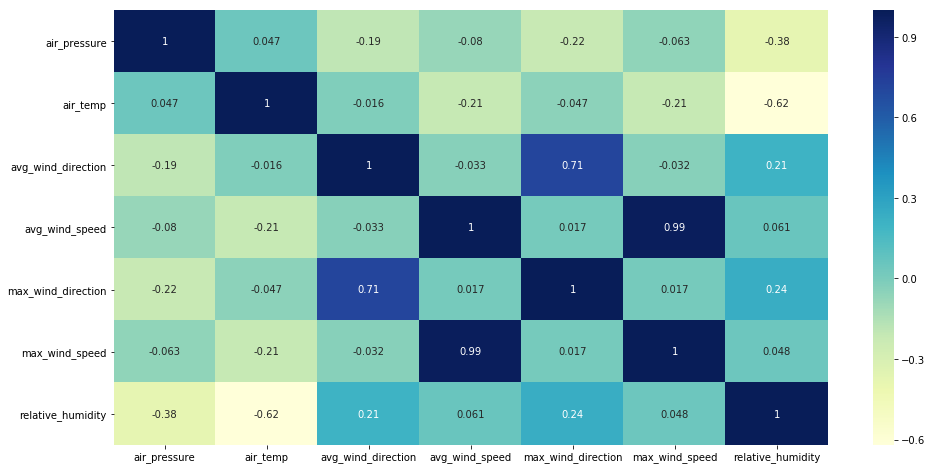

In [98]:
plt.figure(1,figsize=(16,8))
sns.heatmap(c_f,annot=True,cmap='YlGnBu')
plt.show()

# As seen above max wind speed is highly co-related with average wind speed.

In [52]:
select_df.shape

(158680, 7)

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

Scaling the Features using StandardScaler
<br><br></p>


In [42]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

# k-Means Clustering


In [43]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)




# The centers of 12 clusters we formed 



In [45]:
centers = model.cluster_centers_


(12, 7)

In [54]:
for i in centers:
  print(i)

[ 1.36672212 -0.08144984 -1.20745074 -0.04826125 -1.07640575 -0.02786339
 -0.97754978]
[ 0.24833191 -0.99428077  0.65924829 -0.54745716  0.85031207 -0.5301914
  1.1599546 ]
[-1.18062079 -0.87516141  0.44685963  1.97821906  0.53882628  1.93972701
  0.91329738]
[ 0.2335848   0.31908666  1.88785423 -0.65198911 -1.55170741 -0.57683313
 -0.28271609]
[-0.84015634 -1.19876963  0.37507247  0.35830099  0.47346968  0.34629398
  1.3620329 ]
[-0.16300409  0.86356661 -1.31074261 -0.59005703 -1.16635065 -0.6053804
 -0.64164605]
[ 0.13252839  0.8441272   1.41085492 -0.63868345  1.67491165 -0.58939075
 -0.71426312]
[ 1.19074095 -0.25527402 -1.15497682  2.12470392 -1.05349367  2.24158068
 -1.13457013]
[-0.69019787  0.5525602   0.17933647 -0.58465837  0.34915012 -0.59802598
 -0.1197855 ]
[-0.21255699  0.63065165  0.4084465   0.7359804   0.51651156  0.67379899
 -0.14935763]
[ 0.05844501 -0.78689931 -1.19607389 -0.57113683 -1.04198559 -0.58567295
  0.87714786]
[ 0.73718103  0.42502272  0.28603711 -0.53150



# Plots



# utility functions which will help us in plotting graphs:

In [0]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [0]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [0]:
my_colors1 = ['b', 'r', 'g', 'y', 'k','b', 'r', 'g', 'y', 'k']

In [64]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,1.366722,-0.081450,-1.207451,-0.048261,-1.076406,-0.027863,-0.977550,0
1,0.248332,-0.994281,0.659248,-0.547457,0.850312,-0.530191,1.159955,1
2,-1.180621,-0.875161,0.446860,1.978219,0.538826,1.939727,0.913297,2
3,0.233585,0.319087,1.887854,-0.651989,-1.551707,-0.576833,-0.282716,3
4,-0.840156,-1.198770,0.375072,0.358301,0.473470,0.346294,1.362033,4
5,-0.163004,0.863567,-1.310743,-0.590057,-1.166351,-0.605380,-0.641646,5
6,0.132528,0.844127,1.410855,-0.638683,1.674912,-0.589391,-0.714263,6
7,1.190741,-0.255274,-1.154977,2.124704,-1.053494,2.241581,-1.134570,7
8,-0.690198,0.552560,0.179336,-0.584658,0.349150,-0.598026,-0.119785,8
9,-0.212557,0.630652,0.408447,0.735980,0.516512,0.673799,-0.149358,9


In [0]:
import plotly.graph_objs as go

In [0]:
fig1 = px.parallel_coordinates(P[P.relative_humidity<-0.5], color="prediction")
fig1.update_layout(yaxis=dict(range=[-3,3]),)

fig1.show()

# my dry plot

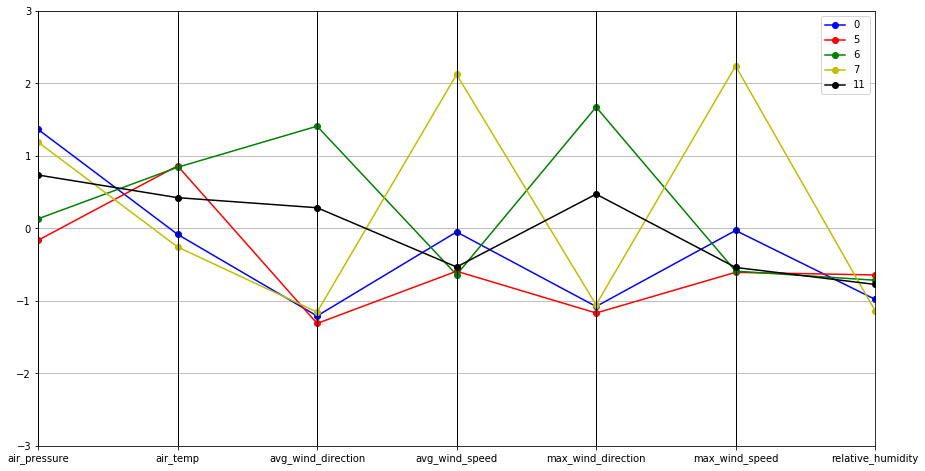

In [90]:
plt.figure(1, figsize=(15,8))
parallel_coordinates(P[P.relative_humidity<(-0.5)], 'prediction',color=my_colors1,marker='o')
plt.ylim(-3,+3)
plt.show()

# Dry Days

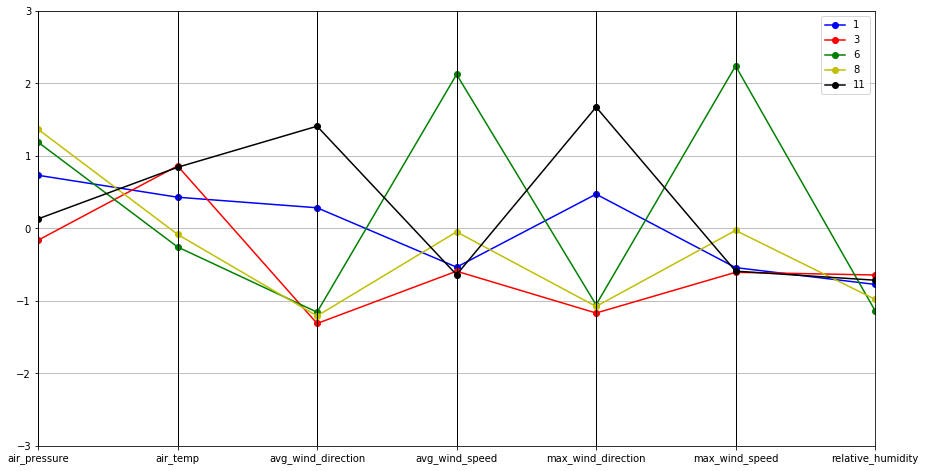

In [0]:
parallel_plot(P[P['relative_humidity'] < -0.5])

# my warm days plot

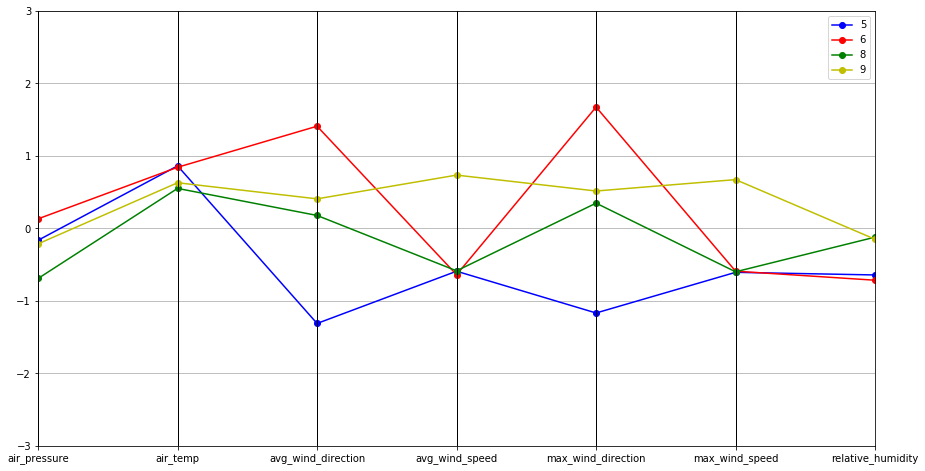

In [91]:
plt.figure(1, figsize=(15,8))
parallel_coordinates(P[P.air_temp>(0.5)], 'prediction',color=my_colors1,marker='o')
plt.ylim(-3,+3)
plt.show()

# Warm Days

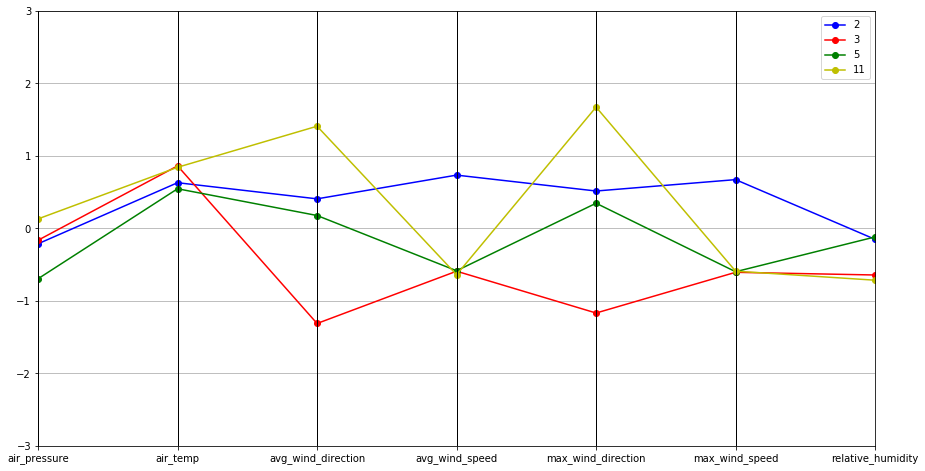

In [0]:
parallel_plot(P[P['air_temp'] > 0.5])

# my cool days plot

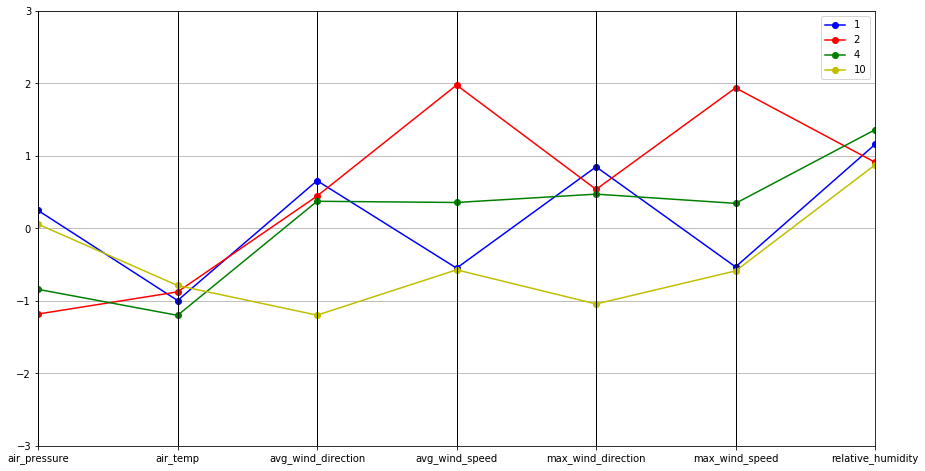

In [92]:
plt.figure(1, figsize=(15,8))
parallel_coordinates(P[(P.relative_humidity>0.5)&(P.air_temp<0.5)], 'prediction',color=my_colors1,marker='o')
plt.ylim(-3,+3)
plt.show()

# Cool Days

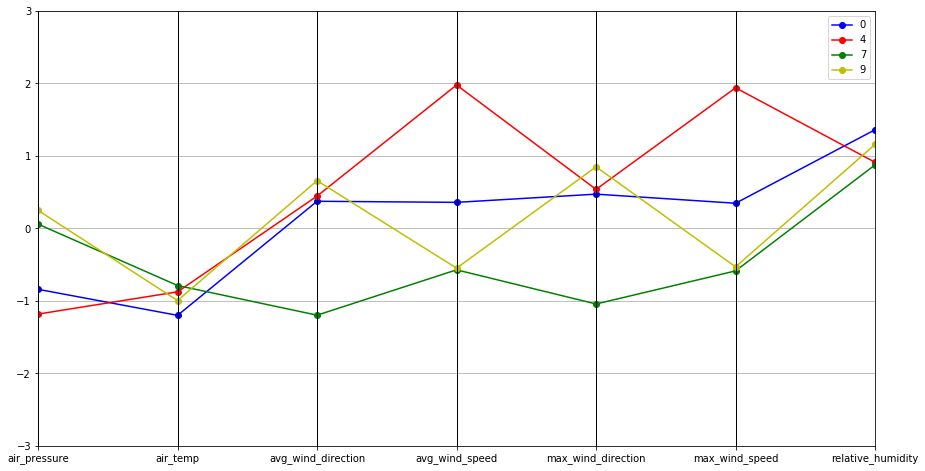

In [0]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])